# Introduction

This notebook compares the test set performance of classifiers using term list scores based on the data-driven, RDoC, and DSM frameworks.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities

## Input parameters

In [2]:
metric = "proto" # Variable being compared between frameworks
n_iter = 1000 # Number of iterations for bootstrap distributions
frameworks = ["data-driven_k08", "data-driven", "rdoc", "dsm"]
clfs = ["_lr", "_lr", "", ""]
list_suffixes = ["", "", "_opsim", "_opsim"]
splits = ["discovery", "replication"]
suffix = "lr"

## Framework contents

In [3]:
lists, circuits = {}, {}
for fw, clf, list_suffix in zip(frameworks, clfs, list_suffixes):
    lists[fw], circuits[fw] = utilities.load_framework(fw, suffix=list_suffix, clf=clf)

## Observed values

In [4]:
obs = {}
for fw, clf in zip(frameworks, clfs):
    obs[fw] = pd.read_csv("data/{}_obs_{}{}.csv".format(metric, fw, clf), index_col=0, header=0)

In [5]:
obs["data-driven_k08"].loc[obs["data-driven_k08"]["SPLIT"] == "discovery"]["OBSERVED"].mean()

0.3793466556438507

In [6]:
obs["data-driven_k08"].loc[obs["data-driven_k08"]["SPLIT"] == "replication"]["OBSERVED"].mean()

0.37830888744984

## Bootstrap distributions

In [7]:
boot, mean = {}, {}
for split in splits:
    boot[split], mean[split] = {}, {}
    for fw, clf in zip(frameworks, clfs):
        boot[split][fw] = pd.read_csv("data/{}_boot_{}{}_{}_{}iter.csv".format(metric, fw, clf, split, n_iter), 
                                      index_col=0, header=0)
        mean[split][fw] = pd.read_csv("data/{}_mean_{}{}_{}.csv".format(metric, fw, clf, split), 
                                      index_col=0, header=0)

# Perform comparison tests

Is the mean of fw<sub>i</sub> greater than the mean of fw<sub>j</sub>?

In [8]:
from statsmodels.stats.multitest import multipletests

In [9]:
interval = 0.999
tail = (1.0 - interval) / 2.0 # Two-sided test
idx_lower = int(n_iter * tail)
idx_upper = int(n_iter * (1.0 - tail))

CI = {}
for split in splits:
    CI[split] = {}
    CI[split] = pd.DataFrame("", index=frameworks, columns=frameworks)
    for i, fw_i in enumerate(frameworks):
        for j, fw_j in enumerate(frameworks):
            boot_i = np.mean(boot[split][fw_i], axis=0)
            boot_j = np.mean(boot[split][fw_j], axis=0)
            boot_dif = np.sort(boot_i - boot_j)
            CI_lower = boot_dif[idx_lower]
            CI_upper = boot_dif[idx_upper]
            CI_sig = ""
            if (CI_lower > 0 and CI_upper > 0) or (CI_lower < 0 and CI_upper < 0):
                CI_sig = "*"
            CI[split].loc[fw_i,fw_j] = "{:.3f}, {:.3f} {}".format(CI_lower, CI_upper, CI_sig)
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(CI[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
                  data-driven_k08       data-driven              rdoc  \
data-driven_k08     0.000, 0.000     -0.041, 0.042     -0.023, 0.057    
data-driven        -0.042, 0.041      0.000, 0.000     -0.023, 0.050    
rdoc               -0.057, 0.023     -0.050, 0.023      0.000, 0.000    
dsm              -0.176, -0.051 *  -0.176, -0.055 *  -0.157, -0.043 *   

                            dsm  
data-driven_k08  0.051, 0.176 *  
data-driven      0.055, 0.176 *  
rdoc             0.043, 0.157 *  
dsm               0.000, 0.000   

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
                  data-driven_k08       data-driven              rdoc  \
data-driven_k08     0.000, 0.000     -0.033, 0.037     -0.025, 0.057    
data-driven        -0.037, 0.03

# Plot evaluation metrics

In [10]:
%matplotlib inline

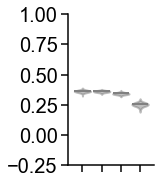

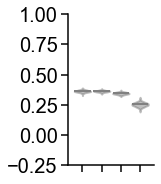

In [11]:
for split in splits:
    utilities.plot_framework_comparison(boot[split], obs, mean[split], metric=metric, w=1.2,
                                        n_iter=n_iter, suffix="k08_" + suffix + "_" + split, 
                                        ylim=[-0.25,1], yticks=[-0.25,0,0.25,0.5,0.75,1])